# Przetwarzanie Obrazow MRI Mozgu, Segmentacja, Architektura U-NET w Keras.

Celem projektu jest poddanie zbioru zdjec tomografii rezonansu magnetycznego
mozgu pacjaentow badanych pod katem obecnosci guza mozgu.

Badany Zbior Danych poddawac bedziemy segmentacji.
**Segmentacja** Zdjec Medycznych to proces automatycznej albo
prawie automatycznej detekcji obszarow w zdjeciach glownie 2D albo 3D.

Rozrozniamy Typy Segmentacji:
* Semantyczna Segmentacja (oznaczamy kazdy piksel)
* Segmentacja Instancji (klasyfikujemy piksele i rozrozniamy instancje obiektow)
i to bedziemy stosowac do porownywania zbiorow danych w numpy.


Wykorzystane Narzedzia:
* Biblioteka Keras ( Biblioteka uczenia maszynowego stworzona na TensorFlow)
* Architektura U-NET ( Sieci Konwolucyjne stworzone specjalnie w celu segmentacji zdjec Biomedycznych)


Architektura U-NET

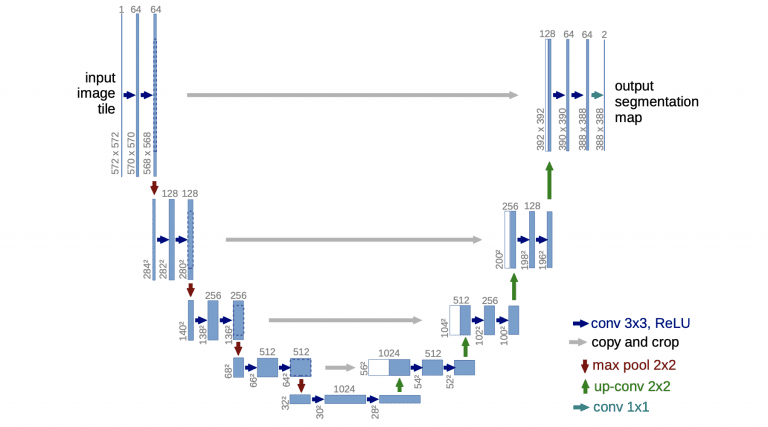




Podstawowe Zrodla:

[1] https://www.analyticsvidhya.com/blog/2021/06/brain-tumor-detection-and-localization-using-deep-learning-part-1/

[2] https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/

[3] https://towardsdatascience.com/medical-images-segmentation-using-keras-7dc3be5a8524

[4] https://arxiv.org/abs/1505.04597




In [3]:
import json
import zipfile
import os
from google.colab import drive
from google.colab import files


# W notebooku dokonamy segmentacji obrazu MRI Raka Mozgu zapisanego DataSecie z kaggle.com
# Na koncu Wytrenujemy Model w ML do przewidywania diagnozy oraz maski dla zdjecia.


# Aby Przeniesc Dane Na Google Collab podazamy sobie za tutorialem
# https://www.kaggle.com/general/156610           : musimy pobrac sobie json'a z danymi do maszyny wirtualnej kaggle
# i instalujemy to na dysku google

# Plik kaggle.json to token z dostepem do naszych data setow ktory musimy pobrac z naszego profilu na kaggle.com

drive.mount('/content/gdrive')


os.chdir("/content/gdrive/MyDrive/Pliki")         # zmieniamy lokalizacje na folder z plikiem json 

!gdown --id kaggle.json

!ls -lha kaggle.json                  # Sprawdzamy istnienie tablicy kaggle.json
!pip install -q kaggle                # instalujemy API kaggle

!mkdir -p .kaggle                     # tworzymy folder dla json
!cp kaggle.json ~/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json  # ustawiamy uprawnienia do dostepu ..

!pwd

!kaggle datasets list                 # sprawdzamy nasze datasety na kaggle                    

!chmod 600 /content/.kaggle/kaggle.json
!kaggle config path -p /content

# Wygenerowany Token:
# ma format: {"username":"jakis_user","key":"f23432424f53f"}



!kaggle datasets download -d azgaltzoar/mrisegmentation


!unzip \*.zip && rm *.zip

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/

# Importujemy Potrzebne Moduly i Bliblioteki

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage import io

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.applications import VGG19

from warnings import filterwarnings
filterwarnings('ignore')

import random

import glob
from IPython.display import display




for dirname, _, filenames in os.walk('/lgg-mri-segmentation'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



data = pd.read_csv('lgg-mri-segmentation/kaggle_3m/data.csv')


data.info()



data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Patient                    110 non-null    object 
 1   RNASeqCluster              92 non-null     float64
 2   MethylationCluster         109 non-null    float64
 3   miRNACluster               110 non-null    int64  
 4   CNCluster                  108 non-null    float64
 5   RPPACluster                98 non-null     float64
 6   OncosignCluster            105 non-null    float64
 7   COCCluster                 110 non-null    int64  
 8   histological_type          109 non-null    float64
 9   neoplasm_histologic_grade  109 non-null    float64
 10  tumor_tissue_site          109 non-null    float64
 11  laterality                 109 non-null    float64
 12  tumor_location             109 non-null    float64
 13  gender                     109 non-null    float64

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0
5,TCGA_CS_5395,2.0,4.0,2,2.0,NaN,3.0,2,3.0,1.0,1.0,3.0,5.0,2.0,43.0,2.0,NaN,1.0
6,TCGA_CS_5396,3.0,3.0,2,3.0,2.0,2.0,3,3.0,2.0,1.0,3.0,2.0,1.0,53.0,3.0,2.0,0.0
7,TCGA_CS_5397,NaN,4.0,1,2.0,3.0,3.0,2,1.0,2.0,1.0,1.0,6.0,1.0,54.0,3.0,2.0,1.0
8,TCGA_CS_6186,2.0,4.0,1,2.0,1.0,3.0,2,2.0,2.0,1.0,3.0,2.0,2.0,58.0,3.0,2.0,1.0
9,TCGA_CS_6188,2.0,4.0,3,2.0,3.0,3.0,2,1.0,2.0,1.0,3.0,6.0,2.0,48.0,3.0,2.0,0.0


In [5]:
data_map = []
for sub_dir_path in glob.glob("lgg-mri-segmentation/kaggle_3m/"+"*"):
    #if os.path.isdir(sub_path_dir):
    try:
        dir_name = sub_dir_path.split('/')[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + '/' + filename
            data_map.extend([dir_name, image_path])
    except Exception as e:
        print(e)

[Errno 20] Not a directory: 'lgg-mri-segmentation/kaggle_3m/README.md'
[Errno 20] Not a directory: 'lgg-mri-segmentation/kaggle_3m/data.csv'


In [6]:


# Zakodowane dane ID pacjenta

df = pd.DataFrame({"patient_id" : data_map[::2],
                   "path" : data_map[1::2]})
df.head()

print(df['path'].values)

dlugosci_sciezek=[]
for row in df['path'].values:
  dlugosci_sciezek.append(len(row))
  

maksymalna_dlugosc=max(dlugosci_sciezek)
print(maksymalna_dlugosc)

#image = cv2.imread(df.path[10])
#plt.imshow(image)




['lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif'
 'lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif'
 'lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10_mask.tif'
 ...
 'lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_8_mask.tif'
 'lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_9.tif'
 'lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_9_mask.tif']
86


In [7]:
df_imgs = df[~df['path'].str.contains("mask")]  # Sciezki Obrazkow Bez Maski
df_masks = df[df['path'].str.contains("mask")]  # Sciezki Obrazkow Z Maska

nazwy_zdjec=[]
print(df_imgs['path'].values)


nazwy_masek=[]
print(df_masks['path'].values)


# dlugosci nazw plikow - ktore mozna sortowac
BASE_LEN = 77       # len("lgg-mri-segmentation/kaggle_3m/TCGA_HT_7684_19950816/TCGA_HT_7684_19950816_2_mask.tif")
END_IMG_LEN = 4     # len(".tif")  .tif czyli 4 znaki
END_MASK_LEN = 9    # (_mask.tif)  _mask.tif czyli 9 znakow


#  Mozemy Posortowac Zdjecia ( Ale nie musimy )

#imgs = sorted(df_imgs['path'].values, key=(lambda x : int(x[BASE_LEN:-END_IMG_LEN]) ))
#masks = sorted(df_masks['path'].values, key=(lambda x : int(x[BASE_LEN:-END_MASK_LEN]) ))

imgs=df_imgs['path'].values
masks=df_masks['path'].values


# Dostep do Sciezki Obrazka oraz Sciezki Obrazka z maska

idx = random.randint(0, len(imgs)-1)
print("Sciezka Do zdjecia:", imgs[idx], "\nSciezka Do Maski:", masks[idx])

['lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif'
 'lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10.tif'
 'lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11.tif'
 ...
 'lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87.tif'
 'lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88.tif'
 'lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_9.tif']
['lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_10_mask.tif'
 'lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_11_mask.tif'
 'lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12_mask.tif'
 ...
 'lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88_mask.tif'
 'lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_8_mask.tif'
 'lgg-mri-segmentation/kaggle_3m

In [8]:
# Ostatecznie Sformatowany DF:
# id_pacjenta : sciezka_obrazka : sciezka_maski

brain_df = pd.DataFrame({"patient_id": df_imgs.patient_id.values,
                         "image_path": imgs,
                         "mask_path": masks
                        })

def pos_neg_diagnosis(mask_path):                   # diagnoza oznaczona wartoscia logiczna 1 albo 0
    value = np.max(cv2.imread(mask_path))
    if value > 0 : 
        return 1
    else:
        return 0


brain_df['mask'] = brain_df['mask_path'].apply(lambda x: pos_neg_diagnosis(x))  # Dodajemy Kolumne Mapujaca Diagnoze : 1 albo 0
brain_df

,patient_id,image_path,mask_path,mask
0,TCGA_CS_4941_19960909,lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19...,lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19...,0
1,TCGA_CS_4941_19960909,lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19...,lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19...,1
2,TCGA_CS_4941_19960909,lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19...,lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19...,1
3,TCGA_CS_4941_19960909,lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19...,lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19...,1
4,TCGA_CS_4941_19960909,lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19...,lgg-mri-segmentation/kaggle_3m/TCGA_CS_4941_19...,1
...,...,...,...,...
3924,TCGA_HT_A61B_19991127,lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19...,lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19...,0
3925,TCGA_HT_A61B_19991127,lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19...,lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19...,0
3926,TCGA_HT_A61B_19991127,lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19...,lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19...,0
3927,TCGA_HT_A61B_19991127,lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19...,lgg-mri-segmentation/kaggle_3m/TCGA_HT_A61B_19...,0


In [10]:
# Wykres Maska a Diagnoza  wartosci logiczne = [0,1]

brain_df['mask'].value_counts()


sns.countplot(brain_df['mask'],palette="Set3")
plt.show()







NameError: ignored

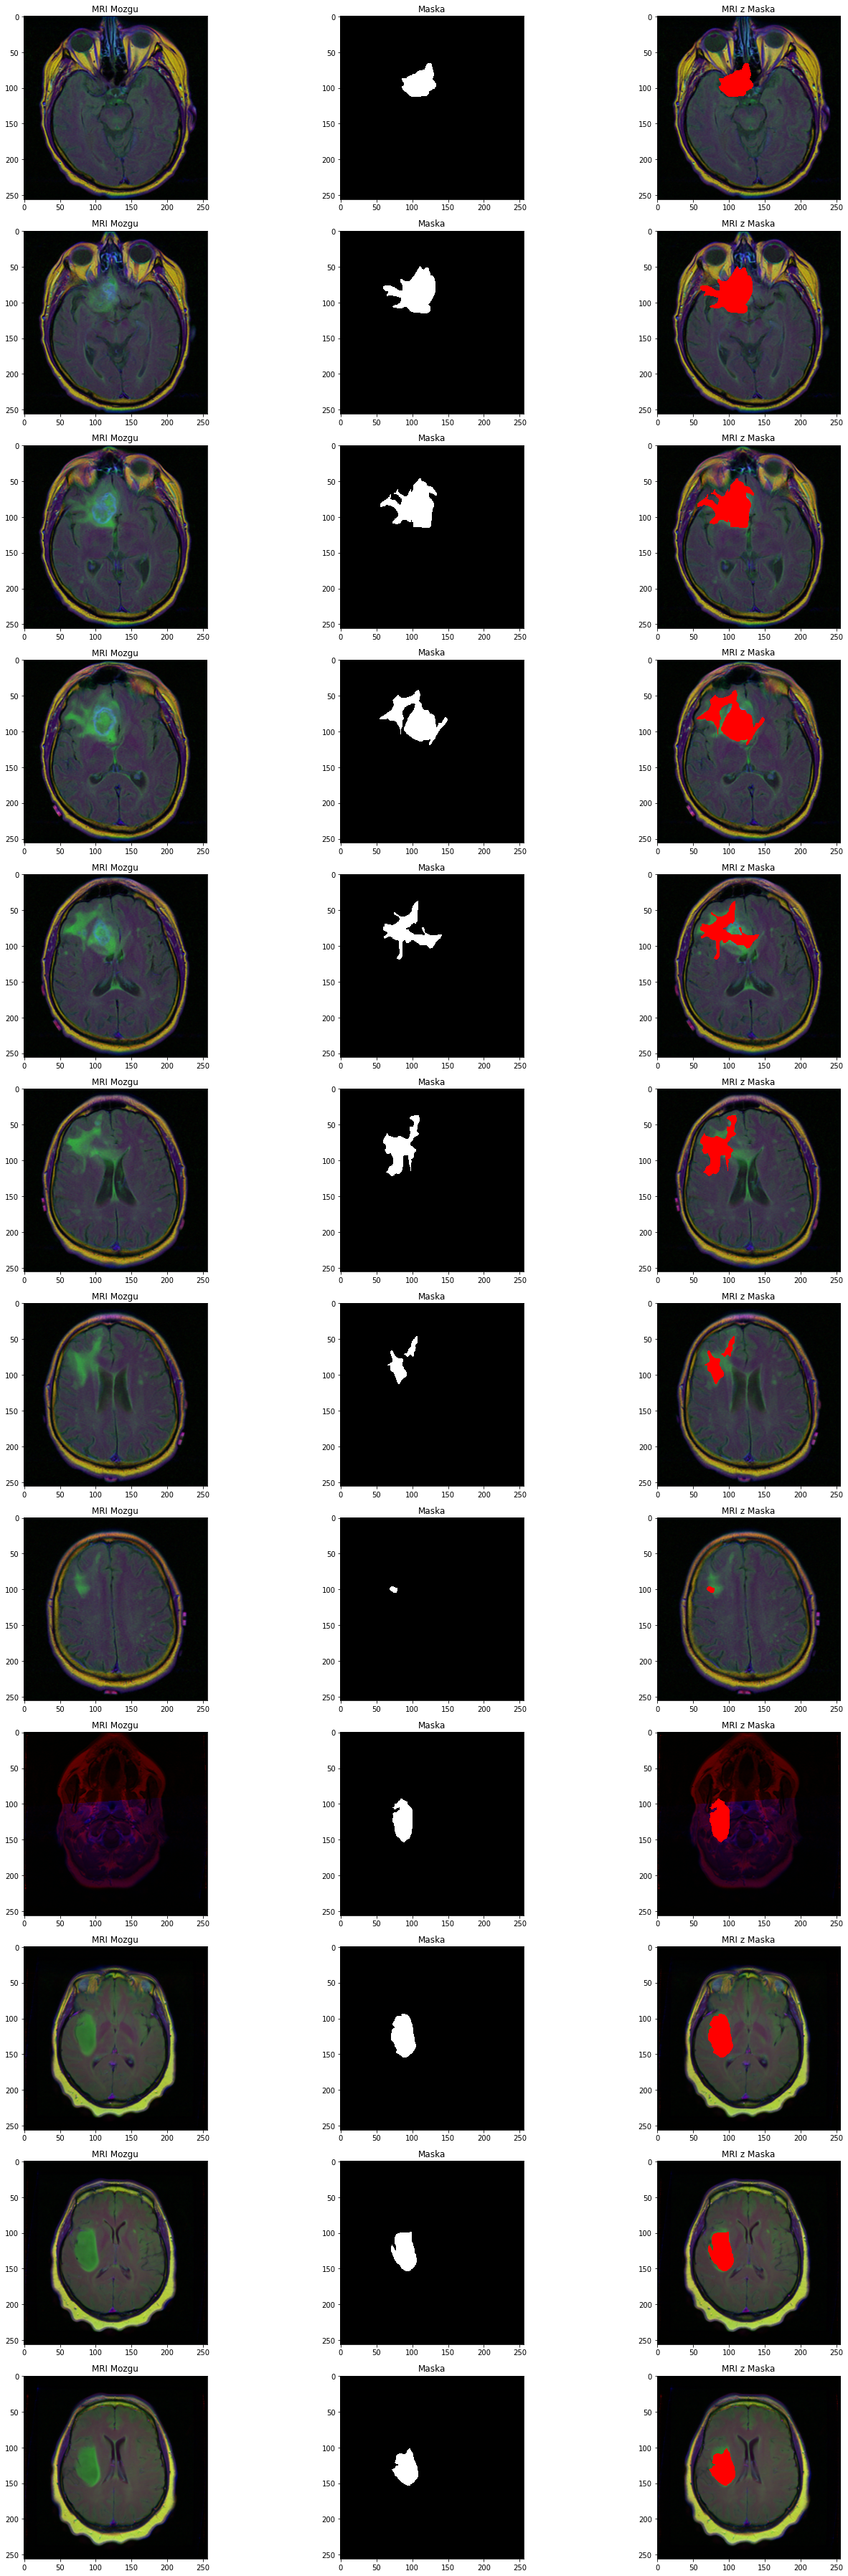

In [11]:


count = 0
i = 0
fig,axs = plt.subplots(12,3, figsize=(20,50))

for mask in brain_df['mask']:
    if (mask==1):
        img = io.imread(brain_df.image_path[i])
        axs[count][0].title.set_text("MRI Mozgu")
        axs[count][0].imshow(img)
        
        mask = io.imread(brain_df.mask_path[i])
        axs[count][1].title.set_text("Maska")
        axs[count][1].imshow(mask, cmap='gray')
        
        img[mask==255] = (255,0,0)                        # zmiana koloru na pozycji piksela dla maski wykrywajacej goza
        axs[count][2].title.set_text("MRI z Maska")
        axs[count][2].imshow(img)
        count +=1
    i += 1
    if (count==12):
        break
        
fig.tight_layout()

# **Trenujemy Modele - Klasyfikacja ML**

 Tworzymy nowego data fram'e dla zbioru treningowego oraz testowego

 Przypomnienie:
*  Training Set - dane do trenowania modelu.
*  Test Set - dane do testowania wytrenowanego modelu.

**Train Data Set**
Data Set ktory wykorzystywany do trenowania uzywanego modelu.
Model "widzi" i "uczy" sie z tych danych.

Chcemy wytrenowac nasz model za pomoca zbioru
treningowego.

Pod te kategorie mozna podpiac Validation Data Set - zbior
wartosci ktore sa wykorzystywane w czasie uczenia sie tego modelu.

**Test Data Set**
Data Set pozwalajacy na ewaluacje ostatecznego modelu aplikowanego
na zbiorze treningowym.

Test DataSet jest uzywany tylko raz kiedy wytrenowalismy juz model.
Test DataSet zawiera dobre, starranie wybrane dane, posiada wiele
klas danych ktore sprawdza sposob radzenia sobie z trudnosciami 
naszego modelu.

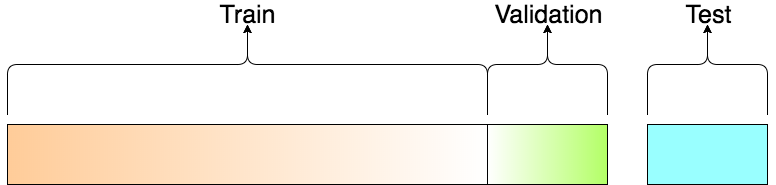



In [12]:

brain_df_train = brain_df.drop(columns=['patient_id'])

brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [13]:
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

(1373, 4)

In [14]:

# Zbior Testowy, Treningowy i zbior wartosci

X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)
print("Rozmiar Train set to {}, poprawny rozmiar to {} & rozmiar zbioru treningowego to {}".format(len(X_train), len(X_val), len(X_test)))

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

Rozmiar Train set to 1167, poprawny rozmiar to 103 & rozmiar zbioru treningowego to 103


In [15]:
# Klasa Zainspirowana z Tutoriali Kaggle :
# Obiekt Klasy Tworzy zbiory X oraz y  : do trenowania oraz z wartosciami dla naszych obrazkow

class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, ids , mask, image_dir = './', batch_size = 16, img_h = 256, img_w = 256, shuffle = True):

    self.ids = ids
    self.mask = mask
    self.image_dir = image_dir
    self.batch_size = batch_size
    self.img_h = img_h
    self.img_w = img_w
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.ids)) / self.batch_size)       # Liczba Porcji Danych Dla epoki

  def __getitem__(self, index):                                 # Getter Partii Danych
                                                                # indeks batch_size length - czyli dlugosci naszej porcji danych
    indexes = self.indexes[index* self.batch_size : (index+1) * self.batch_size]
                                                                # getter Id Obrazka odnoszacego sie do powyzszego indeksu otrzymanego z rozmiaru porcji danych
    list_ids = [self.ids[i] for i in indexes]
    list_mask = [self.mask[i] for i in indexes]                 # getter ID Maski odnoszacego sie do indeksow stworzonych wczesniej na podstawie rozmiaru porcji danych

    # Stworz dane dla X( cechy ) oraz y ( oznaczenie )
    X, y = self.__data_generation(list_ids, list_mask)

    # zwracamy zbiory danych
    return X, y

  def on_epoch_end(self):
    'Aktualizator indeksow po kazdej porcji danych, zarowno na poczatku jak i na koncu '
    # zwracamy tablice indeksow bazujac na wejsciowym df
    self.indexes = np.arange(len(self.ids))

    # jezeli parametr shuffle jest prawdziwy, zwracamy np.shuffle dla indeksow
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_ids, list_mask):
    'Generuj dane odnoszace sie do indeksow danej porcji danych obrazkow MRI'
    # Tworzymy pusta tablice o formacie (rozmiar_danych, wysokosc, szerokosc, glebokosc)
    # Glebokosc to 3 dla wejscia a glbokosc jest brana jako 1 dla wyjscia
    # poniewaz maska sklada sie z jednego kanalu

    X = np.empty((self.batch_size, self.img_h, self.img_w, 3))
    y = np.empty((self.batch_size, self.img_h, self.img_w, 1))

    
    # iterujemy przez dataframe po wierszach, ktorych rozmiar jest rowny batch_size

    for i in range(len(list_ids)):
      
      img_path = str(list_ids[i])     # sciezka obrazka MRI
      mask_path = str(list_mask[i])   # sciezka obrazka MRI z maska
      
      img = io.imread(img_path)       # czytamy oryginalnt obrazek oraz odpowiadajaca mu maske
      mask = io.imread(mask_path)

      img = cv2.resize(img,(self.img_h,self.img_w))     # konwertujemy obrazek na tablice float64
      img = np.array(img, dtype = np.float64)
      
      mask = cv2.resize(mask,(self.img_h,self.img_w))
      mask = np.array(mask, dtype = np.float64)

      # usredniamy dane
      img -= img.mean()
      img /= img.std()
      
      mask -= mask.mean()
      mask /= mask.std()
      
      # Dodajemy obrazek do pustej tablicy
      X[i,] = img
      
      # rozszerzamy wymiar obrazka z (256,256) do (256,256,1)
      y[i,] = np.expand_dims(mask, axis = 2)
    
    # normalizujemy y
    y = (y > 0).astype(int)

    return X, y

train_data = DataGenerator(train_ids, train_mask)
val_data = DataGenerator(val_ids, val_mask)

In [16]:

# Blok Konwolucji
# tworzymy sobie obiekt dla warstwy konwolucji z biblioteki keras
# wywolujemy na nim metody i zwracamy

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x


# Tworzymy obiekt modelu vgg19 u-net 
def build_vgg19_unet(input_shape):
    
    inputs = Input(input_shape)

    """ VGG19 Model przed trenowaniem """
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Enkoder """
    s1 = vgg19.get_layer("block1_conv2").output         
    s2 = vgg19.get_layer("block2_conv2").output         
    s3 = vgg19.get_layer("block3_conv4").output         
    s4 = vgg19.get_layer("block4_conv4").output         

    """ Most """
    b1 = vgg19.get_layer("block5_conv4").output         

    """ Dekoder """
    d1 = decoder_block(b1, s4, 512)                     
    d2 = decoder_block(d1, s3, 256)                     
    d3 = decoder_block(d2, s2, 128)                    
    d4 = decoder_block(d3, s1, 64)                      

    """ Output """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG19_U-Net")
    return model
model = build_vgg19_unet((256,256,3))
model.summary()

80150528/80134624 [==============================] - 0s 0us/step
Model: "VGG19_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 256, 256, 64  36928       ['block1_conv1[0][0]']           
                       

In [17]:
# Define a custom loss function for Vgg19 UNet model

epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def focal_tversky(y_true,y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

In [18]:


# kompilujemy model

adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model.compile(optimizer = adam, 
                  loss = focal_tversky, 
                  metrics = [tversky]
                 )
# callbacki
earlystopping = EarlyStopping(monitor='val_loss',
                              mode='min', 
                              verbose=1, 
                              patience=30
                             )

# zapisujemy najlepszy model z najmniejsza utrata

checkpointer = ModelCheckpoint(filepath="seg_model.h5", 
                               verbose=1, 
                               save_best_only=True
                              )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              mode='min',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )

In [20]:

# dopasowywujemy model wybieramy sobie 60 okresow

history = model.fit(train_data, 
                  epochs = 60, 
                  validation_data = val_data,
                  callbacks = [checkpointer, earlystopping, reduce_lr]
                 )

Epoch 1/60
69/72 [===========================>..] - ETA: 4:56 - loss: 0.7717 - tversky: 0.2902

KeyboardInterrupt: ignored

In [21]:
model = load_model("seg_model.h5",custom_objects={"focal_tversky":focal_tversky,"tversky":tversky,"tversky_loss":tversky_loss})

OSError: ignored

In [ ]:
history.history.keys()

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);
plt.title("SEG Model focal tversky Loss");
plt.ylabel("focal tversky loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

plt.subplot(1,2,2)
plt.plot(history.history['tversky']);
plt.plot(history.history['val_tversky']);
plt.title("SEG Model tversky score");
plt.ylabel("tversky Accuracy");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [ ]:
test_ids = list(X_test.image_path)
test_mask = list(X_test.mask_path)

In [ ]:
def prediction(test, model_seg):
  
    # puste listy na wyniki: maska, id obrazka, wartosc logiczna czy posiada maske
    mask, image_id, has_mask = [], [], []
    
    # iterujemy po kazdym obrazku w danych testowych
    for i in test.image_path:
        

        
        
        # tworzymy pusta tablice numpy o wymiarze 1, 256, 256, 1


        X = np.empty((1,256,256,3))
      
        img = io.imread(i)                # wczytujemy obrazek
        

        img = cv2.resize(img, (256,256))  # zmieniamy rozmiar obrazka i konwertujemy na tablice typu float64
        img = np.array(img, dtype=np.float64)
        
        # usredniamy obrazek
        img -= img.mean()
        img /= img.std()

        # konwertujemy rozmiar obrazka z 256, 256, 3 na 1, 256, 256, 3

        X[0,] = img
        
        
        # przewidujemy maske

        predict = model_seg.predict(X)
        
        # jezeli suma prognozy maski to 0 i nie ma guza

        if predict.round().astype(int).sum()==0:
            image_id.append(i)
            has_mask.append(0)
            mask.append('No mask :)')
        else:
        #if the sum of pixel values are more than 0, then there is tumour
            image_id.append(i)
            has_mask.append(1)
            mask.append(predict)
            
    return pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})

In [ ]:

# Przewidujemy

df_pred = prediction(X_test, model)
df_pred

In [ ]:


# Laczymy Poprzedniego DF z df po prognozie

df_pred = X_test.merge(df_pred, on='image_path')
df_pred.head(10)